In [328]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from sklearn import preprocessing
from collections import Counter

In [5]:
path_dataframes = {
    'metadata': r'D:\personalProject\data\HAM10000_metadata.csv',
}

In [105]:
image_path_0 = r'D:\personalProject\data\HAM10000_images_part_1'
image_path_1 = r'D:\personalProject\data\HAM10000_images_part_2'

In [6]:
df = pd.read_csv(path_dataframes.get('metadata'))

### Data explanation:

 - `bkl` - considered as `benign keratosis-like lesions` - **(benign)** case,
 - `bcc` - `basal cell carcinoma` - **melanoma** case,
 - `akiec` - `Bowen's disease` - easy treatable cancer (**melanoma** case),
 - `df` - dermatofibroma - (**benign** case),
 - `mel`  - **melanoma** case,
 - `nv` - melanocytic nevi (**benign** case),
 - `vasc` - vascular lesions (**benign** case).

In [7]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


### NaN exploration

In [10]:
(df.isna().sum() / df.shape[0]) * 100

lesion_id       0.000000
image_id        0.000000
dx              0.000000
dx_type         0.000000
age             0.569146
sex             0.000000
localization    0.000000
dtype: float64

### Visualize the skin lesions based on their type

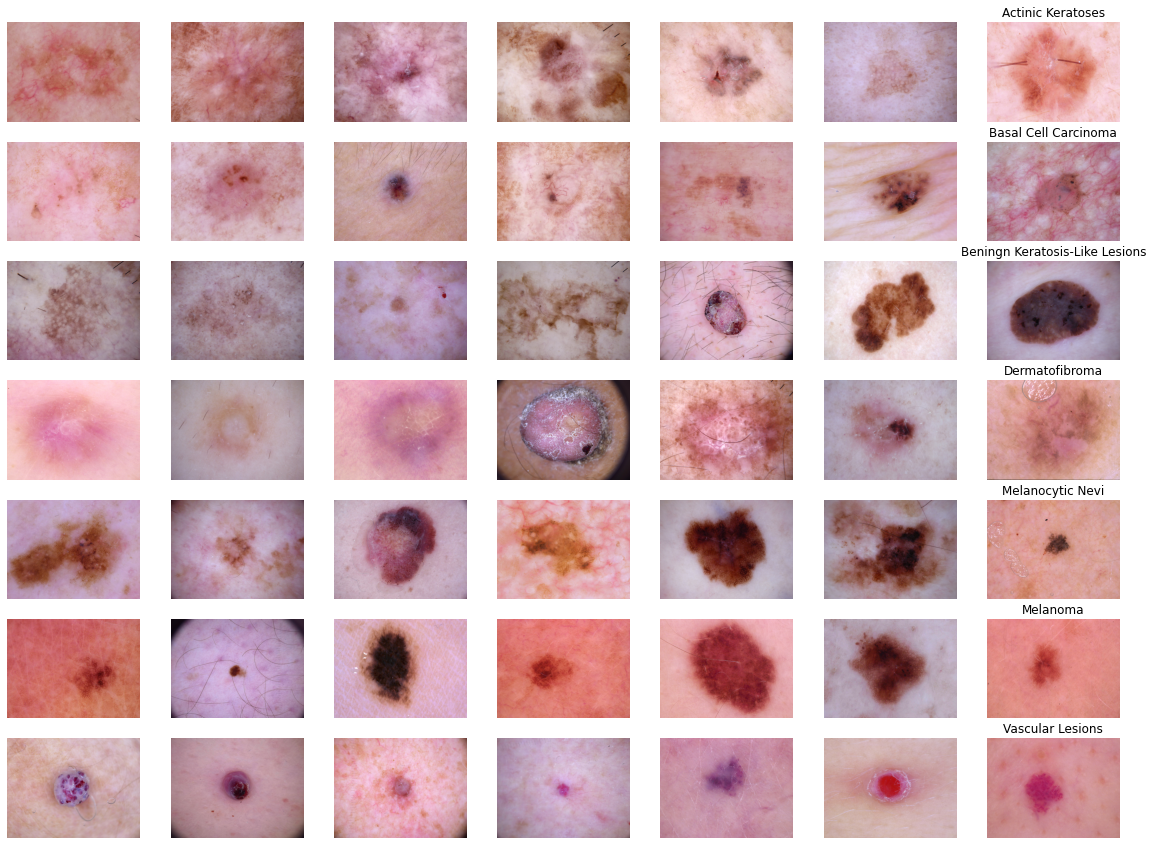

In [376]:
n_images = 7

images = df.sample(frac=1.).groupby('dx').head(n_images).sort_values(by='dx')

fig = plt.figure(figsize=(20, 15))

columns = 7
rows = 7

w = 50
h = 50

skin_lesions_type = [
    'Actinic Keratoses', 
    'Basal Cell Carcinoma', 
    'Beningn Keratosis-Like Lesions',
    'Dermatofibroma',
    'Melanocytic Nevi',
    'Melanoma',
    'Vascular Lesions',
]

for i in range(1, columns * rows + 1):
    
    image_name = images.iloc[i - 1, 1]
    image_path = image_path_0 + r'\\' + image_name + ".jpg"
    
    if not os.path.exists(image_path):
        image_path = image_path_1 + r'\\' + image_name + '.jpg'
    
    image = cv2.imread(image_path, 3)
    image_RGB = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    ax = fig.add_subplot(rows, columns, i)

    if i % rows == 0:
        ax.set_title(skin_lesions_type[i // rows - 1], rotation=0, size='large')
    
    plt.axis('off')
    plt.imshow(image_RGB)

plt.show()


In [259]:
images.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization,mole_type
9820,HAM_0006604,ISIC_0030821,akiec,histo,75.0,male,neck,malignant
9841,HAM_0002615,ISIC_0033413,akiec,histo,70.0,male,scalp,malignant
9794,HAM_0005505,ISIC_0031743,akiec,histo,50.0,male,upper extremity,malignant
9739,HAM_0000967,ISIC_0025539,akiec,histo,75.0,male,lower extremity,malignant
9994,HAM_0000193,ISIC_0030877,akiec,histo,60.0,female,face,malignant
9960,HAM_0002699,ISIC_0029827,akiec,histo,60.0,male,back,malignant
9883,HAM_0000490,ISIC_0026206,akiec,histo,85.0,male,lower extremity,malignant
2767,HAM_0005536,ISIC_0026798,bcc,histo,45.0,male,lower extremity,malignant
2610,HAM_0000263,ISIC_0033001,bcc,histo,70.0,male,back,malignant
2854,HAM_0000872,ISIC_0031171,bcc,histo,75.0,male,chest,malignant


### Check duplicates among images

In [283]:
df.duplicated(subset=['image_id']).sum()

0

In [284]:
df.duplicated(subset=['lesion_id']).sum()

2545

### Age contains 50% or more NaN values, so missing values will be replaced with mean of `age` column.

In [14]:
df.fillna(value={'age': df['age'].mean()}, inplace=True)

### Data distribiution

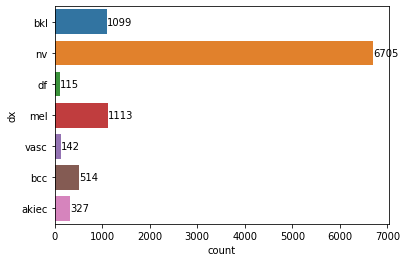

In [70]:
ax = sns.countplot(data=df, y='dx')
ax.bar_label(container=ax.containers[0],);

### Age distribution

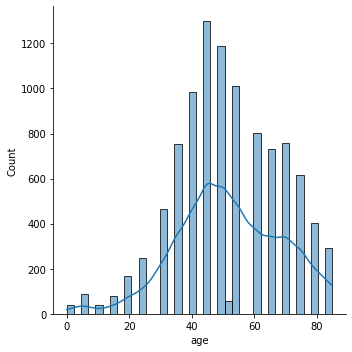

In [53]:
sns.displot(data=df, x='age', kde=True)

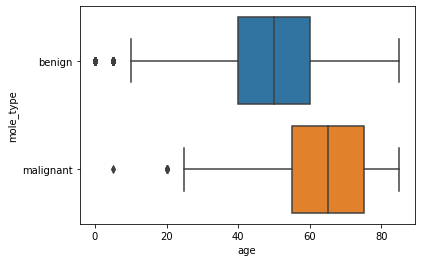

In [261]:
sns.boxplot(data=df, y='mole_type', x='age');

### The type of methodology

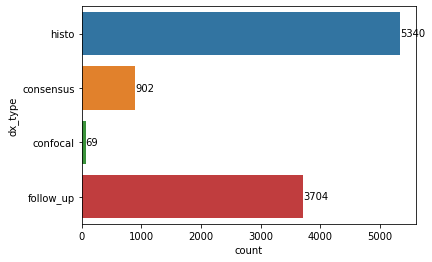

In [71]:
ax = sns.countplot(data=df, y='dx_type')
ax.bar_label(container=ax.containers[0]);

In [72]:
def is_malignant_or_benign(mole_type: str) -> str:
    if mole_type in ['bkl', 'nv', 'df', 'vasc']:
        return 'benign'
    else:
        return 'malignant'
    
df['mole_type'] = df['dx'].map(is_malignant_or_benign)

### Cancer distribution along the age of patients

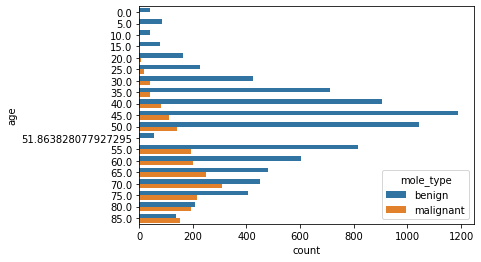

In [86]:
sns.countplot(data=df, y='age', hue='mole_type');

### Cancer based on gender of patients

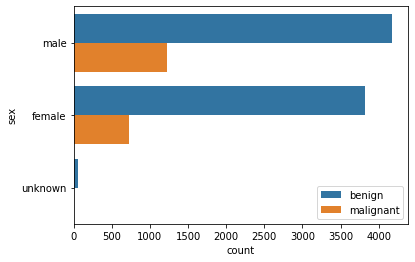

In [90]:
ax = sns.countplot(data=df, y='sex', hue='mole_type');
plt.legend(loc='lower right')

### Benign or Malignant distribution along the parts of the body

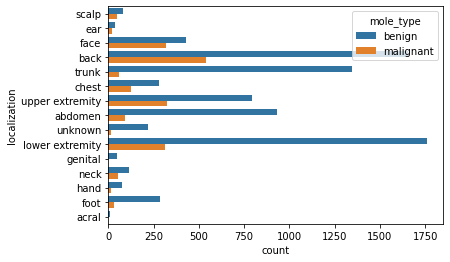

In [95]:
sns.countplot(y='localization', data=df, hue='mole_type');

### Benign vs. Malignant countplot

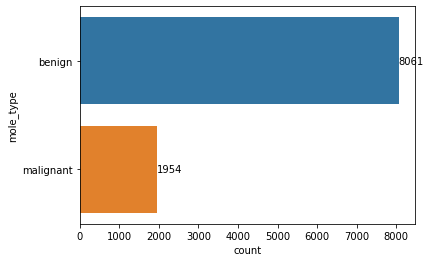

In [104]:
ax = sns.countplot(data=df, y='mole_type')
ax.bar_label(container=ax.containers[0]);

### Probabilities of tumor given a specific body part 

In [128]:
mole_type_per_body_part = df.groupby('localization')['mole_type'].value_counts()

In [136]:
mole_type_per_body_part_df = mole_type_per_body_part.unstack().fillna(0)

In [141]:
mole_type_per_body_part_df.head()

mole_type,benign,malignant
localization,,
abdomen,933.0,89.0
acral,7.0,0.0
back,1653.0,539.0
chest,280.0,127.0
ear,36.0,20.0


In [146]:
mole_type_per_body_part_df['prob'] = round(mole_type_per_body_part_df['malignant'] / mole_type_per_body_part_df.sum(axis=1) * 100, 2)

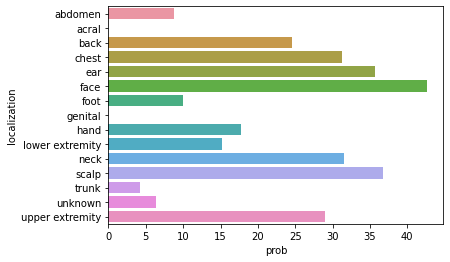

In [149]:
sns.barplot(data=mole_type_per_body_part_df, y=mole_type_per_body_part_df.index, x='prob');

### Check the images in both directories (how many benign and malignant)

In [264]:
images_in_part_1 = os.listdir(image_path_0)

In [271]:
cleared_image_names = [image.replace('.jpg', '', 1) for image in images_in_part_1]

In [274]:
part_1_folder = df.loc[df['image_id'].isin(cleared_image_names)]

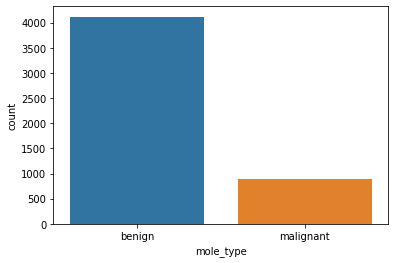

In [276]:
sns.countplot(data=part_1_folder, x='mole_type');

In [277]:
images_in_part_2 = os.listdir(image_path_1)

In [278]:
cleared_image_names_1 = [image.replace('.jpg', '') for image in images_in_part_2]
part_2_folder = df.loc[df['image_id'].isin(cleared_image_names_1)]

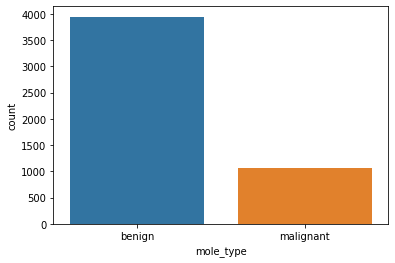

In [280]:
sns.countplot(data=part_2_folder, x='mole_type');

### LabelEncoding based on lesion type

In [323]:
le = preprocessing.LabelEncoder()
le.fit(df.loc[:, 'dx'])
le.classes_

array(['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc'], dtype=object)

In [324]:
lesion_types = le.transform(df.loc[:, 'dx'])

In [327]:
Counter(lesion_types)

Counter({2: 1099, 5: 6705, 3: 115, 4: 1113, 6: 142, 1: 514, 0: 327})

In [340]:
df['lesion_type'] = lesion_types

In [343]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,mole_type,lesion_type
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,benign,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,benign,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,benign,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,benign,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,benign,2


### Lesion ID count

In [361]:
grouped_lesion = df.groupby('lesion_id').count()

grouped_lesion.head()

,image_id,dx,dx_type,age,sex,localization,mole_type,lesion_type
lesion_id,,,,,,,,
HAM_0000000,2,2,2,2,2,2,2,2
HAM_0000001,1,1,1,1,1,1,1,1
HAM_0000002,3,3,3,3,3,3,3,3
HAM_0000003,1,1,1,1,1,1,1,1
HAM_0000004,1,1,1,1,1,1,1,1


In [350]:
without_duplicated_lesions = grouped_lesion.loc[(grouped_lesion['lesion_type'] == 1)]

In [358]:
unique_lesions_df = df.loc[df['lesion_id'].isin(without_duplicated_lesions.index.values)]

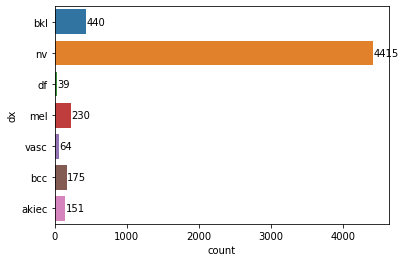

In [373]:
ax = sns.countplot(data=unique_lesions_df, y='dx')
ax.bar_label(container=ax.containers[0]);

In [374]:
df.loc[df['lesion_id'] == 'HAM_0000002']

,lesion_id,image_id,dx,dx_type,age,sex,localization,mole_type,lesion_type
1660,HAM_0000002,ISIC_0033848,mel,histo,65.0,female,lower extremity,malignant,4
1661,HAM_0000002,ISIC_0032622,mel,histo,65.0,female,lower extremity,malignant,4
1662,HAM_0000002,ISIC_0034246,mel,histo,65.0,female,lower extremity,malignant,4


In [378]:
df.to_csv('ham1000_metadata.csv')

In [379]:
unique_lesions_df.to_csv('unique_ham1000_metadata.csv')